In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray

In [3]:
from study import V27, neutral

# Estimate inflow from upstream plane
- velocity profile $= \bar{U}(t,z)$
- $\bar{U}$ is a 1-min rolling mean
- need offset in time from the x=-2.5D plane to the downstream wake planes

In [4]:
casedir = 'WAKEBENCH-NREL_DEBNATH_LES/neutral'
prefix = 'NREL_DEBNATH_LES_20190325'

In [5]:
case = neutral(casedir,prefix,turbine=V27)

In [6]:
-case.upstreamD*V27.D

67.5

## Load data into wake object

In [7]:
xa = xarray.open_dataset(case.get_wake_datafile(case.upstreamD))
xa

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_-2.5D.nc


<xarray.Dataset>
Dimensions:  (t: 1663, x: 1, y: 162, z: 162)
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Data variables:
    U        (t, x, y, z) float64 ...
    V        (t, x, y, z) float64 ...
    W        (t, x, y, z) float64 ...

In [8]:
Ntimes = xa.dims['t']

In [9]:
t = xa.t.values
z = xa.z.values

In [10]:
xa.U

<xarray.DataArray 'U' (t: 1663, x: 1, y: 162, z: 162)>
[43643772 values with dtype=float64]
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Attributes:
    long_name:  streamwise wind component
    units:      m/s

## Estimate profile

In [11]:
Uprofile_inst = xa.U.mean(dim=('x','y')) # average over x,y: U(t,z)

In [12]:
Uprofile_mean = Uprofile_inst.rolling(dim={'t':case.Navg}).mean()

In [13]:
Uprofile = Uprofile_inst.mean(dim='t') # average over t,x,y: U(z)

In [14]:
Uprofile_inst.shape, Uprofile_mean.shape, Uprofile.shape

((1663, 162), (1663, 162), (162,))

In [15]:
# profile envelope
Uprofile_min = Uprofile_inst.min(dim='t')
Uprofile_max = Uprofile_inst.max(dim='t')
Uprofile_std = Uprofile_inst.std(dim='t')

## Plot

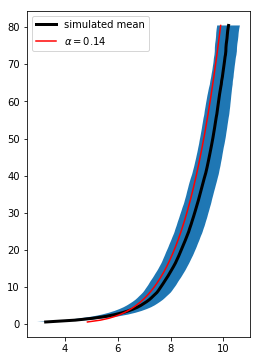

In [32]:
fig,ax = plt.subplots(figsize=(4,6))
ax.plot(Uprofile,z,'k',lw=3,label='simulated mean')
#ax.fill_betweenx(z, Uprofile_min, Uprofile_max)
ax.fill_betweenx(z, Uprofile-Uprofile_std, Uprofile+Uprofile_std)

U_powerlaw = case.Uref * (z/case.turbine.zhub)**case.alpha
ax.plot(U_powerlaw,z,'r',label=r'$\alpha = {:g}$'.format(case.alpha))

ax.legend()

## save data
Values/nans for *rolling mean* `U_mean` of upstream sampled inflow for `Noffset==7`, `Navg==60`, and `Ntimes==1663`:
```
tidx  U(x=-2.5D)      U(x=0)
---  ---------------  -----------
0     nan             ???
7     nan             U_mean(t=0)==nan
59    U_mean(t=59)    U_mean(t=52)==nan
66    U_mean(t=66)    U_mean(t=59)
1655  U_mean(t=1655)  U_mean(t=1648)
1662  U_mean(t=1662)  U_mean(t=1655)
```
Therefore,
- upstream U(t,z) for t $\in$ [`Navg`-1, -`Noffset`]
- inflow U(t,z) for t $\in$ [`Navg`+`Noffset`-1, -1]

In [17]:
# number of planes before inflow hits the rotor
Noffset = int(-case.upstreamD*V27.D / case.Uref)
Noffset

7

In [18]:
case.Navg-1, Ntimes-Noffset-1

(59, 1655)

In [19]:
case.Navg+Noffset-1, Ntimes-1

(66, 1662)

In [20]:
inflow = Uprofile_mean.values

In [21]:
np.savez(os.path.join(casedir,'inflow.npz'), z=z, U=inflow)

DEBUG

In [22]:
# inflow
t[case.Navg-1:-Noffset]

array([16209, 16210, 16211, ..., 17803, 17804, 17805], dtype=uint16)

In [23]:
# wake plane
t[case.Navg+Noffset-1:]

array([16216, 16217, 16218, ..., 17810, 17811, 17812], dtype=uint16)

In [24]:
# wake plane
t[slice(case.Navg+Noffset-1,None)]

array([16216, 16217, 16218, ..., 17810, 17811, 17812], dtype=uint16)